In [4]:
import csv
import numpy as np
import random as rnd
import copy as cp

# Market chain class

In [5]:
class Market_MC:
    def __init__(self, filepath, gap = 0, end = float("inf"), col = 1):
        self.filepath = filepath
        values = []
        #Read the market daily prices form given file
        with open(filepath) as csvData:
            csvReader = csv.reader(csvData)
            i = 0
            for row in csvReader:
                if i >= gap and i <= end:
                    values.append(float(row[col]))
                i += 1
        
        self.value = np.array(values)
        
    def update_params(self, period, start = 0):
    
        movement = self.value[start + 1:(start + period)] >= self.value[start :(start + period-1)]
        #Compute transition probabilities
        b_t_b = np.sum(~(movement[1:] | movement[0:-1]))/np.sum(~movement[0:-1])
        g_t_g = np.sum((movement[1:] & movement[0:-1]))/np.sum(movement[0:-1])
        self.probs = np.array([b_t_b,1-b_t_b,1-g_t_g,g_t_g]).reshape((2,2))
        #Update market state
        self.state = 1 if movement[-1] else 0
        
        return movement
        
    def simulate_market(self, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        new_state = 1
        if rnd_vals[0] < self.probs[self.state][0]:
            new_state = 0
        market_states = [new_state]
    
        for idx, x in enumerate(rnd_vals[1:]):
            #update market state
            new_state = 1
            if x < self.probs[market_states[idx]][0]:
                new_state = 0
            market_states.append(new_state)
        
        return np.array(market_states)

    def set_state(self, state):
        self.state = state

# Stock chain class

In [42]:
class Stock_MC:
    
    def __init__(self, filepath, gap = 0, end = float("inf"), col = 1):
        self.filepath = filepath
        values = []
        #Read the stock daily prices form given file
        with open(filepath) as csvData:
            csvReader = csv.reader(csvData)
            i = 0
            for row in csvReader:
                if i >= gap and i <= end:
                    values.append(float(row[col]))
                i += 1
        
        self.value = np.array(values)
        
    def update_params(self, market_movement, period, start = 0, delta_type = 0):
    
        
        ups = self.value[start + 1:(start + period)] >= self.value[start :(start + period-1)]
        #Compute transition probabilities
        
        #Probabilities for bad market 
        up_b = np.sum(ups[1:] & ~market_movement[1:])/np.sum(~market_movement[1:])
        #self.probs[0][1] = np.sum(ups[1:] & ~market_movement[1:])/(period - 1)
        #self.probs[0][0] = 1 - self.probs[0][1]
        #Probabilities for good market
        up_g = np.sum(ups[1:] & market_movement[1:])/np.sum(market_movement[1:])
        #self.probs[1][1] = np.sum(ups[1:] & market_movement[0:-1])/(period - 1)
        #self.probs[1][0] = 1 - self.probs[1][1]
        self.probs = np.array([1-up_b, up_b, 1-up_g, up_g]).reshape((2,2))
        #Update stock state
        self.state = self.value[start + period - 1]
        #Update stock delta parameter
        if delta_type == 0:
                #Use mean variation as delta
                self.delta = np.mean(np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)]))
        elif delta_type == 1:
                #Use median variation as delta
                self.delta = np.median(np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)]))
        elif delta_type == 2:
                #Use minimum variation as delta
                self.delta = np.quantile(np.absolute(self.value[start + 1:(start + period)] - self.value[start :(start + period-1)]),0.1)
        
        
    def simulate_stock_trajectory(self, market_state, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        stock_states = [(self.state - self.delta) if (rnd_vals[0] <= self.probs[market_state[0]][0]) else (self.state + self.delta)]
            
        for idx, x in enumerate(rnd_vals[1:]):
            #update stock state
            if x <= self.probs[market_state[idx+1]][0]:
                stock_states.append(stock_states[idx] - self.delta)
            else:                           
                stock_states.append(stock_states[idx] + self.delta)

            
        return np.array(stock_states)
    
    def simulate_stock_price(self, market_state, length):
        #Sample lenght random numbers in (0,1)
        rnd_vals = [rnd.uniform(0,1) for i in range(length)]
        end_value = cp.copy(self.state)
        for idx, x in enumerate(rnd_vals):
            #update stock state
            if x <= self.probs[market_state[idx]][0]:
                end_value -= self.delta
            else:
                end_value += self.delta
                
        return end_value
        
    def set_state(self, state):
        self.state = state

In [49]:
from scipy.stats import truncnorm
class Stock_MC2:
    
    def __init__(self, filepath, gap = 0, end = float("inf"), col = 1):
        self.filepath = filepath
        values = []
        #Read the stock daily prices form given file
        with open(filepath) as csvData:
            csvReader = csv.reader(csvData)
            i = 0
            for row in csvReader:
                if i >= gap and i <= end:
                    values.append(float(row[col]))
                i += 1
        
        self.value = np.array(values)
        
    def update_params(self, market_movement, period, start = 0, delta_type = 0):
    
        #Estimate variation parameters
        bad_market = ~market_movement
        good_market = market_movement
        
        price_diff = self.value[start+1:start+period] - self.value[start:start+period-1]
        self.good_mean = np.mean(price_diff[good_market])
        self.good_std = np.std(price_diff[good_market])*0.8
        self.bad_mean = np.mean(price_diff[bad_market])
        self.bad_std = np.std(price_diff[bad_market])*0.8
        #Update state
        self.state = self.value[start + period - 1]
        
        
    def simulate_stock_trajectory(self, market_state, length):
        stock_states = []
        if market_state[0] == 0:
            stock_states.append(self.state + np.random.normal(self.bad_mean, self.bad_std))
        else:                           
            stock_states.append(self.state + np.random.normal(self.good_mean, self.good_std))
            
        for idx in range(length):
            #update stock state
            if market_state[idx] == 0:
                stock_states.append(stock_states[idx] + np.random.normal(self.bad_mean, self.bad_std))
            else:                           
                stock_states.append(stock_states[idx] + np.random.normal(self.good_mean, self.good_std))

            
        return np.array(stock_states)
    
    def simulate_stock_price(self, market_state, length):
        #Sample lenght random numbers in (0,1)
        end_value = cp.copy(self.state)
        for idx in range(length):
            if market_state[idx] == 0:
                end_value += np.random.normal(self.bad_mean, self.bad_std)
            else:                           
                end_value += np.random.normal(self.good_mean, self.good_std)
                
        return end_value
        
    def set_state(self, state):
        self.state = state

# Utility functions

In [51]:
''' S&P500 tickers'''
tickers = ["MMM"  , "ABT"  , "ABBV" , "ACN" ,  "ATVI" , "AYI"  , "ADBE" , "AMD"  , "AAP"  , "AES"  , "AET"  , "AMG"  , "AFL"  , "A"   ,   
"APD"  , "AKAM" , "ALK"  , "ALB" ,  "ARE"  , "ALXN" , "ALGN"  , "AGN"  , "ADS"  , "LNT"  , "ALL"  , "GOOGL", 
"MO"   , "AEE"  , "AAL"  , "AEP" ,  "AXP"  , "AIG"  , "AMT"  , "AWK"  , "AMP"  , "ABC"  , "AME"  , "AMGN" , "APH"  , "APC" , 
"ADI"  , "ANDV" , "ANSS" , "ANTM",  "AON"  , "APA"  , "AIV"  , "AAPL" , "AMAT" , "ADM"  , "ARNC" , "AJG"  , "AIZ" , 
"T"    , "ADSK" , "ADP"  , "AZO" ,  "AVB"  , "AVY"  , "BLL"  , "BAC"  , "BBT"  , "BDX"  , "BRK.B", "BBY"  , "BLK" , 
"HRB"  , "BA"   , "BWA"  , "BXP" ,  "BSX"  , "AVGO" , "BF.B" , "CHRW" , "CA"   , "COG"  , "CDNS" , "CPB" , 
"COF"  , "CAH"  , "CBOE" , "KMX" ,  "CAT"  , "CBG"  , "CBS"  , "CELG" , "CNC"  , "CNP"  , "CTL"  , "CERN" , "CF"   , "SCHW", 
"CHTR" , "CHK"  , "CVX"  , "CMG" ,  "CB"   , "CHD"  , "CI"   , "XEC"  , "CINF" , "CTAS" , "CSCO" , "C"    , "CTXS" , "CLX" , 
"CME"  , "KO"   , "CTSH" , "CL"  ,  "CMCSA", "CMA"  , "CAG"  , "CXO"  , "COP"  , "ED"   , "STZ"  , "COO"  , "GLW"  , "COST", 
"CCI"  , "CSX"  , "CMI" ,  "CVS"  , "DHI"  , "DRI"  , "DVA"  , "DE"   , "DAL"  , "XRAY" , "DVN"  , "DLR" , 
"DFS"  , "DISCA", "DG"   , "DLTR",  "D"    , "DOV"  , "DPS"  , "DTE"  , "DRE"  , "DUK"  , "ETFC" , "EMN" , 
"ETN"  , "ECL"  , "EIX"  , "EW"  ,  "EA"   , "EMR"  , "EOG"  , "EQT"  , "EFX"  , "EQIX" , "EQR"  , "ESS"  , "EL"  , 
"RE"   , "EXC"  , "EXPE",  "EXPD" , "ESRX" , "EXR"  , "XOM"  , "FFIV" , "FB"   , "FAST" , "FRT"  , "FDX"  , "FE"  , 
"FISV" , "FLS"  , "FLR"  , "FMC" ,  "FL"   , "F"    , "FBHS" , "FCX"  , "GPS"  , "GRMN" , "IT"   , "GD"   , "GE"  , 
"GGP"  , "GIS"  , "GM"   , "GPC" ,  "GILD" , "GPN"  , "GS"   , "GT"   , "GWW"  , "HAL"  , "HBI"  , "HOG"  , "HRS"  , "HAS" , 
"HCA"  , "HCP"  , "HP"   , "HES" , "HOLX" , "HD"   , "HON"  , "HRL"  , "HST"  , "HUM"  , "HBAN" , "HII" , 
"IDXX" , "ITW"  , "ILMN" , "IR"  ,  "INTC" , "IBM"  , "INCY" , "IP"   , "IPG"  , "IFF"  , "INTU" , "ISRG" , "IVZ"  , 
"IRM"  , "JEC"  , "JBHT" , "SJM" ,  "JNJ"  , "JCI"  , "JNPR" , "KSU"  , "K"    , "KEY"  , "KMB"  , "KIM"  , "KMI"  , "KLAC", 
"KSS"  , "KR"   , "LB"  ,  "LLL"  , "LH"   , "LRCX" , "LEG"  , "LEN"  , "LUK"  , "LLY"  , "LNC"  , "LKQ"  , "LMT" , 
"L"    , "LOW"  , "LYB"  , "MTB" ,  "MAC"  , "M"    , "MRO"  , "MPC"  , "MAR"  , "MMC"  , "MLM"  , "MAS"  , "MA"   , "MAT" , 
"MKC"  , "MCD"  , "MCK"  , "MDT" ,  "MRK"  , "MET"  , "MTD"  , "MGM"  , "KORS" , "MCHP" , "MU"   , "MSFT" , "MAA"  , "MHK" , 
"TAP"  , "MDLZ" , "MON"  , "MNST",  "MCO"  , "MS"   , "MOS"  , "MSI"  , "MYL"  , "NDAQ" , "NTAP" , "NFLX" , "NWL" , 
"NFX"  , "NEM"  ,  "NEE"  , "NLSN" , "NKE"  , "NI"   , "NBL"  , "JWN"  , "NSC"  , "NTRS" , "NOC"  , "NCLH", 
"NRG"  , "OXY"  , "OMC"  ,  "PCAR" , "PKG"  , "PH"   , "PDCO" , "PAYX" , "PNR"  , "PBCT" , "PEP"  , "PKI" , 
"PRGO" , "PFE"  , "PCG"  , "PM"  ,  "PSX"  , "PNW"  , "PXD"  , "PNC"  , "RL"   , "PPG"  , "PPL"  , "PX"   , "PCLN" , "PFG" , 
"PG"   , "PGR"  , "PLD"  , "PRU" ,  "PEG"  , "PSA"  , "PHM"  , "PVH"  , "PWR"  , "DGX"  , "RRC"  , "RJF"  , "RTN"  ,
"RHT"  , "REG"  , "REGN" , "RF"  ,  "RSG"  , "RMD"  , "RHI"  , "ROK"  , "COL"  , "ROP"  , "ROST" , "RCL"  , "CRM"  , "SBAC", 
"SCG"  , "SLB"  , "SNI"  , "STX" ,  "SEE"  , "SRE"  , "SHW"  , "SIG"  , "SPG"  , "SWKS" , "SLG"  , "SNA"  , "SO"   , "LUV" , 
"SPGI" , "SWK"  , "SBUX" , "STT" ,  "SRCL" , "SYK"  , "STI"  , "SNPS" , "SYY"  , "TROW" , "TPR"  , "TGT"  , "TEL" , 
"FTI"  , "TXN"  , "TXT"  , "TMO" ,  "TIF"  , "TWX"  , "TJX"  , "TMK"  , "TSS"  , "TSCO" , "TDG"  , "TRV"  , "TRIP" , 
"UDR"  , "ULTA" , "USB" ,  "UAA"  , "UNP"  , "UAL"  , "UNH"  , "UPS"  , "URI"  , "UTX"  , "UHS"  , "UNM" , 
"VFC"  , "VLO"  , "VAR"  , "VTR" ,  "VRSN" , "VRSK" , "VZ"   , "VRTX" , "VIAB" , "V"    , "VNO"  , "VMC"  , "WMT"  , "WBA" , 
"DIS"  , "WM"   , "WAT"  , "WFC" ,  "HCN"  , "WDC"  , "WY"   , "WHR"  , "WMB"  , "WYN"  , "WYNN" , "XEL" , 
"XRX"  , "XLNX" , "XL"   , "XYL" ,  "YUM"  , "ZBH"  , "ZION" , "ZTS"]
''' NYSE tickers
tickers = ["A"    , "AAL"  , "AAP"  , "AAPL" , "ABC"  , "ABT" ,  "ACN"  , "ADBE" , "ADI"  , "ADM"  , "ADP"  , "ADS"  , "ADSK" , "AEE" , 
"AEP"  , "AES"  , "AET"  , "AFL"  , "AGN"  , "AIG" ,  "AIV"  , "AIZ"  , "AJG"  , "AKAM" , "ALB"  , "ALK"  , "ALL"  , "ALXN" ,
"AMAT" , "AME"  , "AMG"  , "AMGN" , "AMP"  , "AMT" ,  "AMZN" , "AN"   , "ANTM" , "AON"  , "APA"  , "APC"  , "APD"  , "APH"  ,
"ARNC" , "ATVI" , "AVB"  , "AVGO" , "AVY"  , "AWK" ,  "AXP"  , "AYI"  , "AZO"  , "BA"   , "BAC"  , "BAX"  , "BBBY" , "BBT"  ,
"BBY"  , "BCR"  , "BDX"  , "BEN"  , "BHI"  , "BIIB",  "BK"   , "BLK"  , "BLL"  , "BMY"  , "BSX"  , "BWA"  , "BXP"  , "C"    ,   
"CA"   , "CAG"  , "CAH"  , "CAT"  , "CB"   , "CBG" ,  "CBS"  , "CCI"  , "CCL"  , "CELG" , "CERN" , "CF"   , "CHD"  , "CHK"  ,
"CHRW" , "CI"   , "CINF" , "CL"   , "CLX"  , "CMA" ,  "CMCSA", "CME"  , "CMG"  , "CMI"  , "CMS"  , "CNC"  , "CNP"  , "COF"  ,
"COG"  , "COH"  , "COL"  , "COO"  , "COP"  , "COST",  "CPB"  , "CRM"  , "CSCO" , "CSX"  , "CTAS" , "CTL"  , "CTSH" , "CTXS" ,
"CVS"  , "CVX"  , "CXO"  , "D"    , "DAL"  , "DD"  ,  "DE"   , "DFS"  , "DG"   , "DGX"  , "DHI"  , "DHR"  , "DIS"  , "DISCA",
"DISCK", "DLR"  , "DLTR" , "DNB"  , "DOV"  , "DOW" ,  "DPS"  , "DRI"  , "DTE"  , "DUK"  , "DVA"  , "DVN"  , "EA"   , "EBAY" ,
"ECL"  , "ED"   , "EFX"  , "EIX"  , "EL"   , "EMN" ,  "EMR"  , "ENDP" , "EOG"  , "EQIX" , "EQR"  , "EQT"  , "ES"   , "ESRX" ,
"ESS"  , "ETFC" , "ETN"  , "ETR"  , "EW"   , "EXC" ,  "EXPD" , "EXPE" , "EXR"  , "F"    , "FAST" , "FCX"  , "FDX"  , "FE"   ,   
"FFIV" , "FIS"  , "FISV" , "FITB" , "FL"   , "FLIR",  "FLR"  , "FLS"  , "FMC"  , "FOX"  , "FOXA" , "FRT"  , "FSLR" , "FTI"  ,
"FTR"  , "GD"   , "GE"   , "GGP"  , "GILD" , "GIS" ,  "GLW"  , "GOOG" , "GOOGL", "GPC"  , "GPN"  , "GPS"  , "GRMN" , "GS"   ,   
"GT"   , "GWW"  , "HAL"  , "HAR"  , "HAS"  , "HBAN",  "HBI"  , "HCN"  , "HCP"  , "HD"   , "HES"  , "HIG"  , "HOG"  , "HOLX" ,
"HON"  , "HP"   , "HPQ"  , "HRB"  , "HRL"  , "HRS" ,  "HSIC" , "HST"  , "HSY"  , "HUM"  , "IBM"  , "ICE"  , "IDXX" , "IFF"  ,
"ILMN" , "INTC" , "INTU" , "IP"   , "IPG"  , "IR"  ,  "IRM"  , "ISRG" , "ITW"  , "IVZ"  , "JBHT" , "JCI"  , "JEC"  , "JNJ"  ,
"JNPR" , "JPM"  , "JWN"  , "K"    , "KEY"  , "KIM" ,  "KLAC" , "KMB"  , "KMX"  , "KO"   , "KR"   , "KSS"  , "KSU"  , "L"    ,   
"LB"   , "LEG"  , "LEN"  , "LH"   , "LKQ"  , "LLL" ,  "LLTC" , "LLY"  , "LMT"  , "LNC"  , "LNT"  , "LOW"  , "LRCX" , "LUK"  ,
"LUV"  , "LVLT" , "M"    , "MA"   , "MAA"  , "MAC" ,  "MAR"  , "MAS"  , "MAT"  , "MCD"  , "MCHP" , "MCK"  , "MCO"  , "MDLZ" ,
"MDT"  , "MET"  , "MHK"  , "MJN"  , "MKC"  , "MLM" ,  "MMC"  , "MMM"  , "MNST" , "MO"   , "MON"  , "MOS"  , "MRK"  , "MRO"  ,
"MSFT" , "MSI"  , "MTB"  , "MTD"  , "MU"   , "MUR" ,  "MYL"  , "NBL"  , "NDAQ" , "NEE"  , "NEM"  , "NFLX" , "NFX"  , "NI"   ,   
"NKE"  , "NOC"  , "NOV"  , "NRG"  , "NSC"  , "NTAP",  "NTRS" , "NUE"  , "NVDA" , "NWL"  , "O"    , "OKE"  , "OMC"  , "ORCL" ,
"ORLY" , "OXY"  , "PAYX" , "PBCT" , "PBI"  , "PCAR",  "PCG"  , "PCLN" , "PDCO" , "PEG"  , "PEP"  , "PFE"  , "PFG"  , "PG"   ,   
"PGR"  , "PH"   , "PHM"  , "PKI"  , "PLD"  , "PM"  ,  "PNC"  , "PNR"  , "PNW"  , "PPG"  , "PPL"  , "PRGO" , "PRU"  , "PSA"  ,
"PVH"  , "PWR"  , "PX"   , "PXD"  , "QCOM" , "R"   ,  "RAI"  , "RCL"  , "REGN" , "RF"   , "RHI"  , "RHT"  , "RIG"  , "RL"   ,   
"ROK"  , "ROP"  , "ROST" , "RRC"  , "RSG"  , "RTN" ,  "SBUX" , "SCG"  , "SCHW" , "SE"   , "SEE"  , "SHW"  , "SIG"  , "SJM"  ,
"SLB"  , "SLG"  , "SNA"  , "SNI"  , "SO"   , "SPG" ,  "SPGI" , "SPLS" , "SRCL" , "SRE"  , "STI"  , "STT"  , "STX"  , "STZ"  ,
"SWK"  , "SWKS" , "SWN"  , "SYK"  , "SYMC" , "SYY" ,  "T"    , "TAP"  , "TDC"  , "TEL"  , "TGNA" , "TGT"  , "TIF"  , "TJX"  ,
"TMK"  , "TMO"  , "TROW" , "TRV"  , "TSCO" , "TSN" ,  "TSO"  , "TSS"  , "TWX"  , "TXN"  , "TXT"  , "UAA"  , "UAL"  , "UDR"  ,
"UHS"  , "ULTA" , "UNH"  , "UNM"  , "UNP"  , "UPS" ,  "URBN" , "URI"  , "USB"  , "UTX"  , "V"    , "VAR"  , "VFC"  , "VIAB" ,
"VLO"  , "VMC"  , "VNO"  , "VRSK" , "VRSN" , "VRTX",  "VTR"  , "VZ"   , "WAT"  , "WBA"  , "WDC"  , "WEC"  , "WFC"  , "WFM"  ,
"WHR"  , "WM"   , "WMB"  , "WMT"  , "WU"   , "WY"  ,  "WYN"  , "WYNN" , "XEC"  , "XEL"  , "XL"   , "XLNX" , "XOM"  , "XRAY" ,
"XRX"  , "YHOO" , "YUM"  , "ZBH"  , "ZION"]
'''
#Stocks and market MC
data_path = './data2/'
Stocks = {ticker : Stock_MC2(data_path+ticker+'_prices.csv') for ticker in tickers}
Market = Market_MC(data_path+'market_prices.csv')


#Set starting time
init_period = 500
#length = 1762 #NYSE legnth
length = 1259 #S&P500 length
max_time = length - 1
#Step size 0 = 7gg, 1 = 15gg, 2 = 30gg
step_size = 1
#Initialize parameters of the market and stock chains
market_movement = Market.update_params(init_period)
for tick in tickers:
    Stocks[tick].update_params(market_movement, init_period)

In [52]:
import scipy.optimize as sciopt


#Read stocks historical returns
def read_returns():
    rets = np.empty((len(tickers), length))
    for idx, tick in enumerate(tickers):
        t_rets = []
        with open(data_path+tick+'_returns.csv') as csvFile:
            reader = csv.reader(csvFile)
            for row in reader:
                t_rets.append(float(row[step_size]))
        rets[idx] = t_rets
    return rets

Stock_returns = read_returns()

def estimate_cov_matrix(rets, period, start):
    variance = np.var(rets, axis=1)
    correlation = np.corrcoef(Stock_returns[:,start:(start+period)])
    return np.multiply(np.sqrt(variance.reshape((1,len(variance)))*variance.reshape((len(variance),1))),correlation)

#Function to obtain the optimal portfolio
def optimal_portfolio(e_returns, cov_mat):
    obj = lambda x : -1*(np.dot(x,e_returns)/np.dot(x,np.dot(cov_mat,x)))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,np.random.random(len(tickers)), bounds=bound_ctr , constraints=sum_ctr)).x
#Function to obtain the optimal portfolio
def optimal_portfolio2(e_returns):
    obj = lambda x : -1*np.dot(x,e_returns)
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,np.random.random(len(tickers)), bounds=bound_ctr , constraints=sum_ctr)).x
#Function to obtain the optimal portfolio
def optimal_portfolio3(e_returns, cov_mat):
    obj = lambda x : -1*np.dot(x,e_returns)+np.dot(x,np.dot(cov_mat,x))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,np.random.random(len(tickers)), bounds=bound_ctr , constraints=sum_ctr)).x
#Function to obtain the optimal portfolio
def optimal_portfolio4(e_returns, cov_mat):
    obj = lambda x : -1*(np.dot(x,e_returns)/1.05*np.dot(x,np.dot(cov_mat,x)))
    bound_ctr = [(0,1) for i in range(len(tickers))]
    sum_ctr = [{'type' : 'ineq' , 'fun' : lambda x : np.sum(x) - 1}, {'type' : 'ineq' , 'fun' : lambda x : 1 - np.sum(x)}]
    return (sciopt.minimize(obj,np.random.random(len(tickers)), bounds=bound_ctr , constraints=sum_ctr)).x

def evaluate_portfolio(portofolio, start, end):
    initial_value = 0
    for idx,x in enumerate(tickers):
        initial_value += portofolio[idx]*Stocks[x].value[start]
    end_value = 0
    for idx,x in enumerate(tickers):
        end_value += portofolio[idx]*Stocks[x].value[end]
    return (end_value - initial_value)/initial_value


# Portofolio investment experiment

In [53]:
time = init_period - 1
window = 0
if step_size == 0:
    window = 7
elif step_size == 1:
    window = 15
elif step_size == 2:
    window = 30

n_simuls = 200
portfolio_performance = []
market_performance = []
while time <= max_time - window:
    
    print(time)
    stock_returns = np.empty((len(tickers),n_simuls))
    for i in range(n_simuls):
        market_simulation = Market.simulate_market(window)
        for idx,x in enumerate(tickers):
            stock_returns[idx][i] = (Stocks[x].simulate_stock_price(market_simulation, window) - Stocks[x].state)/Stocks[x].state
    #opt_portfolio = optimal_portfolio(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))
    #opt_portfolio = optimal_portfolio2(np.mean(stock_returns,axis=1))
    #opt_portfolio = optimal_portfolio3(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))
    opt_portfolio = optimal_portfolio4(np.mean(stock_returns,axis=1), estimate_cov_matrix(stock_returns,init_period,time-init_period+1))

    portfolio_performance.append(evaluate_portfolio(opt_portfolio,time, time+window))
    market_performance.append((Market.value[time+window]-Market.value[time])/Market.value[time])
    time += window
    for x in tickers:
        Stocks[x].set_state(Stocks[x].value[time])

file_name = 'performance_' + str(window) + '.csv'
with open(file_name, 'w') as outFile:
    writer = csv.writer(outFile)
    for x in portfolio_performance:
        writer.writerow([x])

        

499
514
529
544
559
574
589
604
619
634
649
664
679
694
709
724
739
754
769
784
799
814
829
844
859
874
889
904
919
934
949
964
979
994
1009
1024
1039
1054
1069
1084
1099
1114
1129
1144
1159
1174
1189
1204
1219
1234


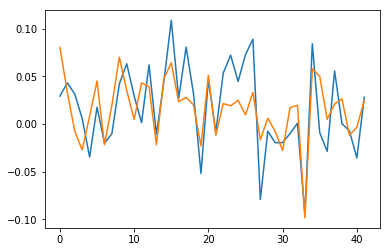

In [93]:
## Non randomized variations
import matplotlib.pyplot as plt
plt.plot(portfolio_performance)
plt.plot(market_performance)
plt.show()

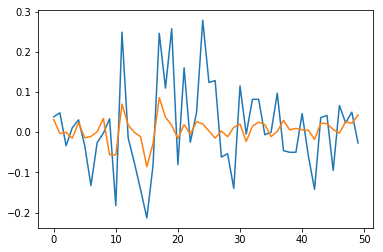

In [54]:
## Randomized variations
import matplotlib.pyplot as plt
plt.plot(portfolio_performance)
plt.plot(market_performance)
plt.show()